In [1]:
import pims

def import_dataset(name_folder):
    """
    Imports and cleans up the data files in the name directory (removes
    incompletely scanned frames) and exports the resulting file as a
    TIFF file along with the relevant metadata. All files are exported
    to a "preprocessed_data" folder in the name folder (created if it
    does not already exist).
    
    :param str name_folder: Path to name folder containing data files.
    :return: 
    """
    

In [1]:
import pims
import glob

In [119]:
trim_series = False

In [2]:
name_folder = 'test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1'
dataset_name = name_folder.split('/')[-1]
file_path = ''.join([name_folder, '/', dataset_name, '*'])
file_list = glob.glob(file_path)

In [115]:
data = []
metadata = []

for file in file_list:
    series = pims.Bioformats(file)
    series.bundle_axes = 'tczyx'
    data.append(series)

    metadata.append(series[0].metadata)

In [ ]:
for series in data:
    if trim_series:
        

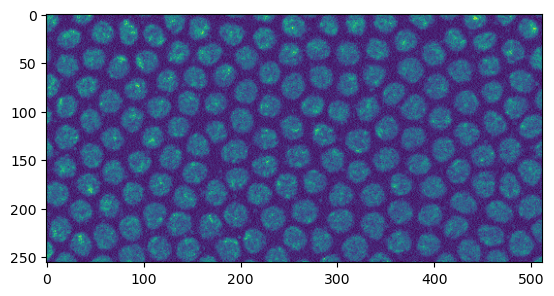

In [75]:
import matplotlib.pyplot as plt
plt.imshow(data[0][0][100][1][12])

In [71]:
print(data[0].shape)

(1, 144, 2, 21, 256, 512)


In [69]:
data[0].sizes

{'x': 512, 'y': 256, 'c': 2, 't': 144, 'z': 21}

In [100]:
ts = (data[0][0][0][1][5].metadata)['t_s']

In [117]:
metadata[1]

{'frame': array([[[  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,
           24,  26,  28,  30,  32,  34,  36,  38,  40],
         [  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,
           25,  27,  29,  31,  33,  35,  37,  39,  41]],
 
        [[ 42,  44,  46,  48,  50,  52,  54,  56,  58,  60,  62,  64,
           66,  68,  70,  72,  74,  76,  78,  80,  82],
         [ 43,  45,  47,  49,  51,  53,  55,  57,  59,  61,  63,  65,
           67,  69,  71,  73,  75,  77,  79,  81,  83]],
 
        [[ 84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104, 106,
          108, 110, 112, 114, 116, 118, 120, 122, 124],
         [ 85,  87,  89,  91,  93,  95,  97,  99, 101, 103, 105, 107,
          109, 111, 113, 115, 117, 119, 121, 123, 125]],
 
        [[126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148,
          150, 152, 154, 156, 158, 160, 162, 164, 166],
         [127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149,
          151, 153, 155, 157, 

In [111]:
ts[3][0][18]

49.72336128000097

In [113]:
data[0][0].metadata

{'frame': array([[[   0,    2,    4, ...,   36,   38,   40],
         [   1,    3,    5, ...,   37,   39,   41]],
 
        [[  42,   44,   46, ...,   78,   80,   82],
         [  43,   45,   47, ...,   79,   81,   83]],
 
        [[  84,   86,   88, ...,  120,  122,  124],
         [  85,   87,   89, ...,  121,  123,  125]],
 
        ...,
 
        [[5922, 5924, 5926, ..., 5958, 5960, 5962],
         [5923, 5925, 5927, ..., 5959, 5961, 5963]],
 
        [[5964, 5966, 5968, ..., 6000, 6002, 6004],
         [5965, 5967, 5969, ..., 6001, 6003, 6005]],
 
        [[6006, 6008, 6010, ..., 6042, 6044, 6046],
         [6007, 6009, 6011, ..., 6043, 6045, 6047]]]),
 'series': 0,
 'colors': [(0.0, 1.0, 0.0), (1.0, 0.0, 0.0)],
 'mpp': 0.2075664552409598,
 'mppZ': 0.5,
 'x': 0,
 'y': 0,
 'c': array([[[0, 0, 0, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1]